In [1]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
import numpy as np
import pandas as pd
from chromax import Simulator
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from tqdm import tqdm
import os
os.environ["KERAS_BACKEND"] = "jax"


2023-12-29 14:33:39.423958: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

def plot_means_and_variances(dataframes):
    # Calculate the mean and variance for each dataframe
    mean_values = [df.mean() for df in dataframes]
    var_values = [df.var() for df in dataframes]
    var_values = np.array(var_values).flatten()
    mean_values = np.array(mean_values).flatten()

    # Create an array for the x-values
    x_values = range(len(dataframes))

    # Create the scatter plot with error bars
    plt.errorbar(x_values, mean_values, yerr=var_values, fmt='o')

    # Display the plot
    plt.show()


def generate_genetic_map(n_markers, n_chromosomes):
  df = pd.DataFrame(generate_marker_effects(n_markers=n_markers), columns=['Yield'])
  df['cM'] = np.random.uniform(0, 200, len(df))
  df['CHR.PHYS'] = '1A'
  df = df.sort_values(by='cM')
  df = df[['CHR.PHYS', 'cM', 'Yield']]
  # save df as csv under filename
  return df

def generate_population(n_pop=100, n_markers=500):
    """
    Generate a numpy array of randoms of length 500 with randomized 0, 1, or 2 at each position.
    It will generate 100 individuals based on n_pop.

    Returns: numpy array of size (n_pop, n_markers)
    """
    shape=(n_pop, n_markers, 2)
    # Define the elements to choose from and their associated probabilities
    elements = [0, 1, 2]
    probabilities = [1/3, 1/3, 1/3]  # equal probabilities for 0, 1, and 2

    # Generate the population
    population = np.random.choice(elements, size=(n_pop, n_markers), p=probabilities)

    return np.random.choice([True, False], size=shape)


def generate_marker_effects(n_markers=500, mu=0, sigma=0.1):
    """
    Generate a numpy array of marker effects with a normal distribution.

    Parameters:
    n_markers (int): Number of markers.
    mu (float): Mean of the distribution.
    sigma (float): Standard deviation of the distribution.

    Returns:
    numpy array of marker effects
    """

    # Generate the marker effects
    marker_effects = np.random.normal(mu, sigma, n_markers)

    return marker_effects


def select_random_individuals(arr, num_individuals):
    # Get the shape of the array
    shape = arr.shape

    # Generate random indices along the first axis
    idx = np.random.choice(shape[0], size=num_individuals)

    # Select the random individuals

    return random_individuals

def select_mixed(population, random_split=.99):
  n_pop = population.shape[0]

  n_random = int(n_pop * random_split)
  n_select = int(n_pop * (1-random_split))

  random_parents = select_random_individuals(Farm.current_population, n_random)
  selected_parents = Farm.Simulator.select(Farm.current_population, k = n_select)
  combined_arr = np.concatenate((random_parents, selected_parents), axis=0)
  return combined_arr

def plot_replicate_means_and_variances(replicate_data, start_index=None, end_index=None):
    # Create a new figure and axes
    fig, ax = plt.subplots()

    # If start_index or end_index is not provided, set them to default values
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(replicate_data[0])

    # For each list of dataframes in replicate_data
    for i, dataframes in enumerate(replicate_data):
        # Select the dataframes in the specified range
        dataframes = dataframes[start_index:end_index]

        # Calculate the mean and variance for each dataframe
        mean_values = [df.mean() for df in dataframes]
        var_values = [df.var() for df in dataframes]

        # Flatten the var_values and mean_values lists to 1D arrays
        var_values = np.array(var_values).flatten()
        mean_values = np.array(mean_values).flatten()

        # Create an array for the x-values
        x_values = range(len(dataframes))

        # Plot the means with error bars for the variances
        ax.errorbar(x_values, mean_values, yerr=var_values, fmt='o', label=f'Replicate {i+1}')

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()


def plot_replicate_means(replicate_data):
    # Create a new figure and axes
    fig, ax = plt.subplots()

    # For each list of dataframes in replicate_data
    for i, dataframes in enumerate(replicate_data):
        # Calculate the mean for each dataframe
        mean_values = [df.mean() for df in dataframes]
        # Flatten the mean_values list to a 1D array
        mean_values = np.array(mean_values).flatten()

        # Create an array for the x-values
        x_values = range(len(dataframes))

        # Plot the means as a line plot
        ax.plot(x_values, mean_values, label=f'Replicate {i+1}')

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()

def parse_markerEffects(genetic_map, nChr):
    # Get the length of the genetic map
    length = len(genetic_map)

    # Create a new array for storing the chromosome number for each marker
    chr = [0] * length

    # Calculate the number of markers per chromosome
    markers_per_chr = length // nChr

    # Iterate over the range of the genetic map length
    for i in range(length):
        # Calculate the chromosome number and store it in the chr array
        chr[i] = i // markers_per_chr + 1

    return chr

def score_top(scores: pd.DataFrame, column: str, k: int):
    # Sort the DataFrame from high to low
    sorted_scores = scores.sort_values(by=column, ascending=False)
    # Get the top K indexes
    top_k_indexes = sorted_scores.head(k).index
    return top_k_indexes


def score_top_percentile(scores: pd.DataFrame, column: str, percentile_min: float, percentile_max: float, k: int):
    # Ensure max percentile is greater than min percentile
    assert percentile_max > percentile_min, "Error: max percentile should be greater than min percentile"
    
    # Calculate the percentiles
    lower = scores[column].quantile(percentile_min)
    upper = scores[column].quantile(percentile_max)
    # Filter the DataFrame
    filtered_scores = scores[(scores[column] >= lower) & (scores[column] <= upper)]
    # Sample k random indexes
    sampled_indexes = np.random.choice(filtered_scores.index, k, replace=True)

    return sampled_indexes

def reshape_pop(maizeHaplo):
    reshapeHaplo = maizeHaplo.reshape(int((maizeHaplo.shape[0])/2),2,maizeHaplo.shape[1])
    reshapeHaplo = reshapeHaplo.transpose((0,2,1))
    return reshapeHaplo

def return_genetic_map_df(markerEffects, nChr, geneticMap):
    chr = parse_markerEffects(markerEffects, nChr)
    chr = [int(x[0]) for x in chr]
    trait = markerEffects
    pos = geneticMap
    # Assuming chr, trait, pos are your arrays
    df = pd.DataFrame({'CHR.PHYS': chr, 'Yield': trait, 'cM': pos})
    return df

import matplotlib.pyplot as plt

def plot_histogram(ax, probabilities, label=None, color=None):
    ax.hist(probabilities, bins='auto', density=True, alpha=0.5, label=label, color=color)
    ax.set_title('Probability Distribution')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Frequency')

def plot_bar(ax, probabilities, label=None, color=None):
    indices = range(len(probabilities))
    ax.bar(indices, probabilities, alpha=0.5, label=label, color=color)
    ax.set_title('Probability per Index')
    ax.set_xlabel('Index')
    ax.set_ylabel('Probability')

def plot_probabilities(probabilities1, probabilities2):
    # Create subplots: 1 row, 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Call the plot functions for the first set of probabilities
    plot_histogram(axs[0], probabilities1, label='Probabilities 1', color='blue')
    plot_bar(axs[1], probabilities1, label='Probabilities 1', color='blue')

    # Call the plot functions for the second set of probabilities
    plot_histogram(axs[0], probabilities2, label='Probabilities 2', color='red')
    plot_bar(axs[1], probabilities2, label='Probabilities 2', color='red')

    # Add legends
    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')

    # Display the plots
    plt.tight_layout()  # Adjusts subplot params so that subplots fit in the figure area
    plt.show()

def select_parent(probabilities):
    try:
        # Ensure probabilities sum up to 1
        probabilities = np.array(probabilities, dtype=np.float64)
        probabilities[-1] = max(0, 1 - np.sum(probabilities[:-1]))
        indices = np.arange(len(probabilities))  # Create an array of indices
        sampled_index = np.random.choice(indices, p=probabilities)  # Sample an index based on the probabilities
    except ValueError:
        print("Error: probabilities do not sum up to 1")
        print("Probabilities:", probabilities)
        raise
    return sampled_index



In [3]:
%%R
x <- seq(0, 2*pi, length.out=50)

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [4]:
%R -o x

In [5]:
x

array([0.        , 0.12822827, 0.25645654, 0.38468481, 0.51291309,
       0.64114136, 0.76936963, 0.8975979 , 1.02582617, 1.15405444,
       1.28228272, 1.41051099, 1.53873926, 1.66696753, 1.7951958 ,
       1.92342407, 2.05165235, 2.17988062, 2.30810889, 2.43633716,
       2.56456543, 2.6927937 , 2.82102197, 2.94925025, 3.07747852,
       3.20570679, 3.33393506, 3.46216333, 3.5903916 , 3.71861988,
       3.84684815, 3.97507642, 4.10330469, 4.23153296, 4.35976123,
       4.48798951, 4.61621778, 4.74444605, 4.87267432, 5.00090259,
       5.12913086, 5.25735913, 5.38558741, 5.51381568, 5.64204395,
       5.77027222, 5.89850049, 6.02672876, 6.15495704, 6.28318531])

In [6]:
# %R install.packages("AlphaSimR")

In [7]:
%%R
library("AlphaSimR")

Loading required package: R6


In [8]:
%%R
nInd = 50
nChr = 2
segSites = 20

founderGenomes = runMacs(nInd = nInd,
                         nChr = nChr,
                         segSites = segSites,
                         species = "MAIZE")


In [9]:
%%R
SP = SimParam$new(founderGenomes)
SP$addTraitA(segSites)
# SP$setVarE(h2=.02)
pop = newPop(founderGenomes, simParam=SP)
ans = fastRRBLUP(pop, simParam=SP, useQtl=TRUE, use='gv')
ans@gv[[1]]@addEff
markerEffects = slot(slot(ans, "gv")[[1]], "addEff")
maizeHaplo = pullSegSiteHaplo(pop)
maizeGeno = pullSegSiteGeno(pop)
#cm positions of each marker
genMap = SP$genMap
geneticMap = unlist(genMap)

In [10]:
%R -o maizeHaplo
%R -o maizeGeno
%R -o markerEffects
%R -o geneticMap
%R -o nInd
%R -o nChr
%R -o segSites

In [11]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape

#create init population + genetic map
n = int(nInd)
m = int((segSites * nChr))
d = 2
total_parents = n*2 # pop size per cycle



def calculate_true_reward(simulator, current_population, new_population):
    true_reward = simulator.GEBV(new_population).mean() - simulator.GEBV(current_population).mean()
    return true_reward

def calculate_critic_loss(true_reward, critic_output):
    return (true_reward - critic_output)**2
    

def create_actor():
    # Define the actor model
    actor_input = keras.layers.Input(shape=(n, m, d))
    x = Flatten()(actor_input)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(n * total_parents, activation='linear')(x)
    x = Reshape((total_parents, n))(x)
    actor_output = keras.layers.Softmax(axis=-1)(x)
    actor_model = keras.models.Model(actor_input, actor_output)
    actor_model.compile(optimizer='adam', loss='categorical_crossentropy')
    return actor_model

def create_critic():
    # Define the critic model
    critic_input1 = keras.layers.Input(shape=(n, m, d))
    critic_input2 = keras.layers.Input(shape=(total_parents, n))

    x1 = Flatten()(critic_input1)
    x1 = Dense(64, activation='relu')(x1)

    x2 = Flatten()(critic_input2)
    x2 = Dense(64, activation='relu')(x2)

    combined = keras.layers.concatenate([x1, x2])

    x3 = Dense(64, activation='relu')(combined)
    critic_output = Dense(1, activation='linear')(x3)

    critic_model = keras.models.Model([critic_input1, critic_input2], critic_output)
    critic_model.compile(optimizer='adam', loss='mse')
    return critic_model


def calculate_actor_loss(actor_output, selected_array):
    #calculate actor loss
    actor_log_probs = tf.math.log(actor_output)  #log probabilities of the actions given by the actor
    selected_log_probs = tf.gather(actor_log_probs, selected_array, axis=1)  #log probabilities of the selected actions
    loss = -tf.reduce_sum(selected_log_probs)  #negative sum of the log probabilities of the selected actions
    return loss

@tf.function
def actor_train_step(actor_model, optimizer, loss, example_population, selected_array):
    with tf.GradientTape() as tape:
        predicted_actions = actor_model(example_population)
        actor_loss = loss(predicted_actions, selected_array)
    gradients = tape.gradient(actor_loss, actor_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, actor_model.trainable_variables))
    return actor_loss


@tf.function
def critic_train_step(critic_model, optimizer, example_population, actor_output, past_fitness):
    with tf.GradientTape() as tape:
        predicted_rewards = critic_model([ example_population, actor_output])
        critic_loss = (past_fitness - predicted_rewards) ** 2
    gradients = tape.gradient(critic_loss, critic_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, critic_model.trainable_variables))
    return critic_loss
import random

import random

def simplify_geneticmap(lst, qtl):
    # Select 'qtl' random indexes
    indexes_positive = random.sample(range(len(lst)), qtl)
    
    # Select 'qtl' random indexes not already selected
    remaining_indexes = set(range(len(lst))) - set(indexes_positive)
    indexes_negative = random.sample(remaining_indexes, qtl)

    # Modify the list
    for i in range(len(lst)):
        if i in indexes_positive:
            lst[i] = random.uniform(0.5, 1.0)  # Assign random float between 0.5 and 1.0
        elif i in indexes_negative:
            lst[i] = random.uniform(-0.5, -1.0)  # Assign random float between -0.5 and -1.0
        else:
            lst[i] = 0  # Assign 0

    return lst



import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(file_path):
    """
    Load the numpy array from the specified file path.
    """
    return np.load(file_path)

def sum_ploidy_values(data):
    """
    Sum the ploidy values in the data.
    """
    return np.sum(data, axis=2)

def create_heatmap(data, title="Heatmap of Ploidy Values", xlabel="Marker Index", ylabel="Individual Index"):
    """
    Create a heatmap from the provided data.
    """
    # Choosing a visually appealing color scheme
    cmap = sns.color_palette(["#1f77b4", "#ff7f0e", "#2ca02c"], as_cmap=True)

    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(data, cmap=cmap, cbar=False)

    # Creating a color bar manually
    cbar = ax.figure.colorbar(ax.collections[0])
    cbar.set_ticks([0.33, 1, 1.67])
    cbar.set_ticklabels(['0', '1', '2'])
    cbar.set_label('Summed Ploidy Value')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

In [12]:
def plot_allele_frequencies(data, marker_strength, sort_by_allele_0=False, bar_width=0.8):
    """
    Plot the frequencies of alleles 0 and 1 for each marker in the data,
    with an option to sort by allele 0 frequency, and color code the background
    of marker position labels based on their strength.

    :param data: Numpy array of shape (n, m, d) where n is the number of individuals,
                 m is the number of markers, and d is ploidy (assumed to be 2 in this case).
    :param marker_strength: List of strength values for each marker.
    :param sort_by_allele_0: Boolean, if True, sort markers by allele 0 frequency.
    :param bar_width: Width of the bars in the plot.
    """
    allele_counts = np.apply_along_axis(lambda x: np.bincount(x, minlength=3), axis=2, arr=data)
    total_allele_counts = allele_counts.sum(axis=0)
    allele_frequencies = total_allele_counts / total_allele_counts.sum(axis=1)[:, np.newaxis]

    allele_0_proportions = allele_frequencies[:, 0]
    allele_1_proportions = allele_frequencies[:, 1]
    x_positions = np.arange(1, len(allele_0_proportions) + 1)

    # Normalize marker_strength for color mapping
    normalized_strength = (np.array(marker_strength) + 1) / 2  # Normalize to range [0, 1]

    # Create a colormap from red to green
    cmap = plt.cm.RdYlGn

    # Sorting the markers by allele 0 frequency if required
    if sort_by_allele_0:
        sorted_indices = np.argsort(-allele_0_proportions)
        allele_0_proportions = allele_0_proportions[sorted_indices]
        allele_1_proportions = allele_1_proportions[sorted_indices]
        normalized_strength = normalized_strength[sorted_indices]

    # Plotting
    plt.figure(figsize=(15, 8))
    for xpos, a0, a1, strength in zip(x_positions, allele_0_proportions, allele_1_proportions, normalized_strength):
        plt.bar(xpos, a0, color='red', edgecolor='black', width=bar_width, label='Allele 0' if xpos == 1 else "")
        plt.bar(xpos, a1, bottom=a0, color='black', edgecolor='black', width=bar_width, label='Allele 1' if xpos == 1 else "")
        plt.text(xpos, -0.05, f'{xpos}', horizontalalignment='center', verticalalignment='center', 
                 color='white', fontsize=8, fontweight='bold', 
                 bbox=dict(facecolor=cmap(strength), edgecolor='none', boxstyle='round,pad=0.2'))

    plt.ylim(-0.15, 1)  # Adjust y-limits to accommodate marker labels
    plt.ylabel('Proportion')
    plt.xlabel('Marker Position')
    plt.title('Proportion of Alleles 0 and 1 at Each Marker' + (' (Sorted by Allele 0)' if sort_by_allele_0 else ''))
    plt.legend(loc='upper right')

    plt.show()



In [13]:
class BreedingProgram:
    """
    Represents a breeding program with a PPO agent.
    """

    def __init__(self, initial_population, genetic_map, population_size, marker_count, chromosome_number, max_generation, heritability):
        """
        Initializes the breeding program.
        """

        # Initialize the basic attributes
        self.population_size = population_size
        self.marker_count = marker_count
        self.initial_population = initial_population
        self.genetic_map = genetic_map
        self.max_generation = max_generation
        self.marker_strength = np.array(self.genetic_map['Yield'])

        # Initialize the simulator
        self.simulator = Simulator(genetic_map=self.genetic_map, h2=heritability)
        self.simulator.load_population('mypop.npy')

        # Initialize the current generation and history
        self.current_generation = 0
        self.history = []

        # Initialize the Actor and Critic models
        self.actor = create_actor()
        self.critic = create_critic()
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

                # Start the breeding program
        self._start_breeding_program()
        
    def _start_breeding_program(self):
        """
        Starts the breeding program.
        """
        self.current_population = self.initial_population
        self.current_scores = self.simulator.GEBV(self.initial_population)
        self.history.append(self.current_scores)
 
    def run_episodes(self,num_episodes, num_cycles):
        frames = []
        for _ in tqdm(range(num_episodes)):
            self.current_population = self.initial_population
            for cycle_iter in range(num_cycles):
                # Get model outputs
                current_pop = self.current_population.reshape(1,*self.current_population.shape)
                actor_output = self.actor(current_pop)
                critic_output = self.critic([ current_pop, actor_output])
                #sample an action from the actors policy
                action_selections = [select_parent(x) for x in actor_output[0,:,:]]
                # Reshape action selections into pairs of parents for chromax
                selected_array = np.array([action_selections[i:i+2] for i in range(0, len(action_selections), 2)])
                # print(selected_array)
                # make the crosses
                new_population = self.simulator.cross(current_pop[0][selected_array])
                actor_loss = actor_train_step(self.actor, self.actor_optimizer, calculate_actor_loss, current_pop, selected_array)
                critic_loss = critic_train_step(self.critic, self.critic_optimizer, current_pop, actor_output, past_fitness=self.simulator.GEBV(self.current_population[0]).mean()[0])
                #Update population
                self.current_population = np.array(new_population)
                if cycle_iter == (num_cycles-1):
                    critic_loss_list.append(critic_loss.numpy()[0][0])
                    mean_score_list.append(self.simulator.GEBV(new_population).mean()[0])
                    # fig = create_plot(new_population, self.marker_strength)
                    # frames.append([fig])
        # ani = ArtistAnimation(fig, frames, interval=200, blit=True, repeat_delay=1000)
        # ani.save('training_animation.gif', writer='imagemagick')
    def view_policy(self):
        current_pop = self.current_population.reshape(1,*self.current_population.shape)
        return self.actor(current_pop)




initial_population =  reshape_pop(maizeHaplo) 
genetic_map = return_genetic_map_df(markerEffects, nChr, geneticMap)
genetic_map['Yield'] = simplify_geneticmap(list(genetic_map['Yield']),15)
reshapeHaplo = reshape_pop(maizeHaplo)
np.save('mypop', reshapeHaplo)
print(f'reshape haplo {reshapeHaplo.shape}')
population_size = int(nInd)
marker_count = int((segSites * nChr))
chromosome_number = int(nChr)
max_generation = 10
heritability = .95
mean_score_list=[]
critic_loss_list=[]

farm  = BreedingProgram(initial_population, genetic_map, population_size, marker_count, chromosome_number, max_generation, heritability)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


reshape haplo (50, 40, 2)


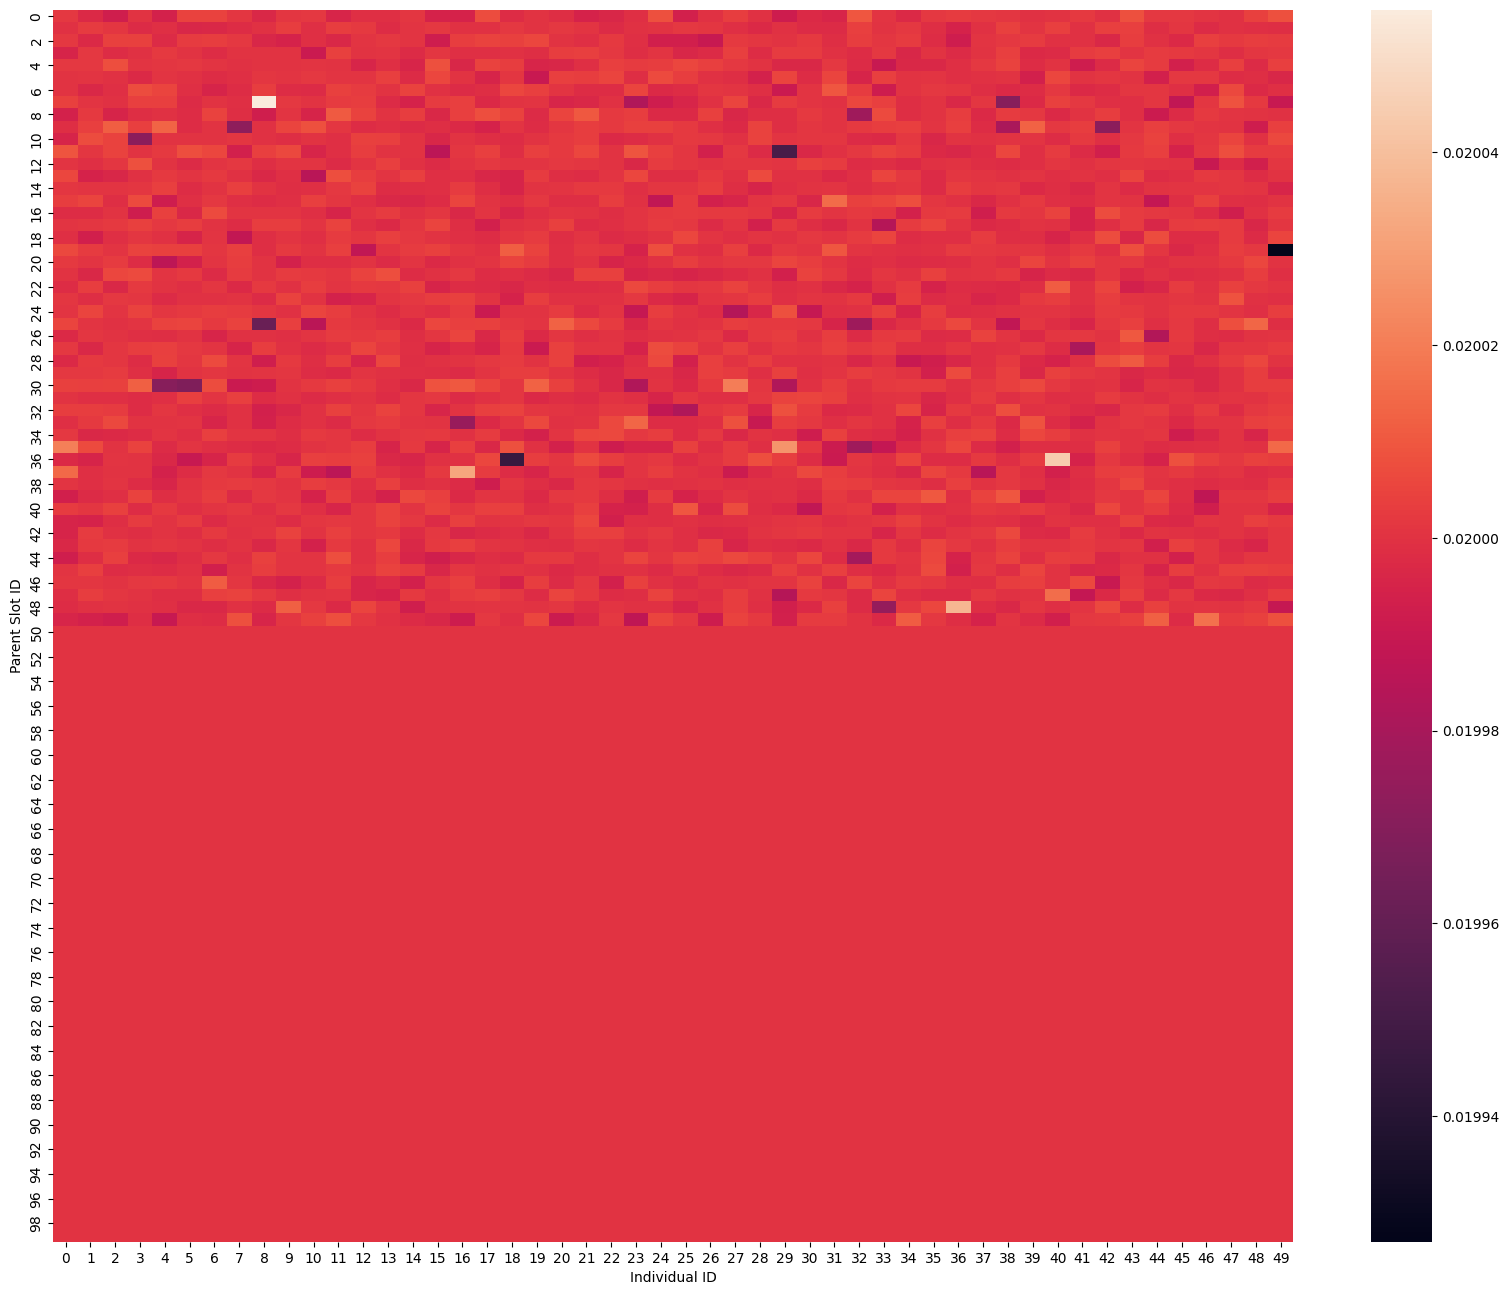

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

mydata = farm.view_policy().numpy()

plt.figure(figsize=(20, 16))  # Set the figure size
sns.heatmap(mydata[0])  # Create the heatmap
plt.xlabel('Individual ID')  # Add x-axis label
plt.ylabel('Parent Slot ID')  # Add y-axis label
plt.show()  # Display the heatmap


In [18]:
farm.run_episodes(10,10)

100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


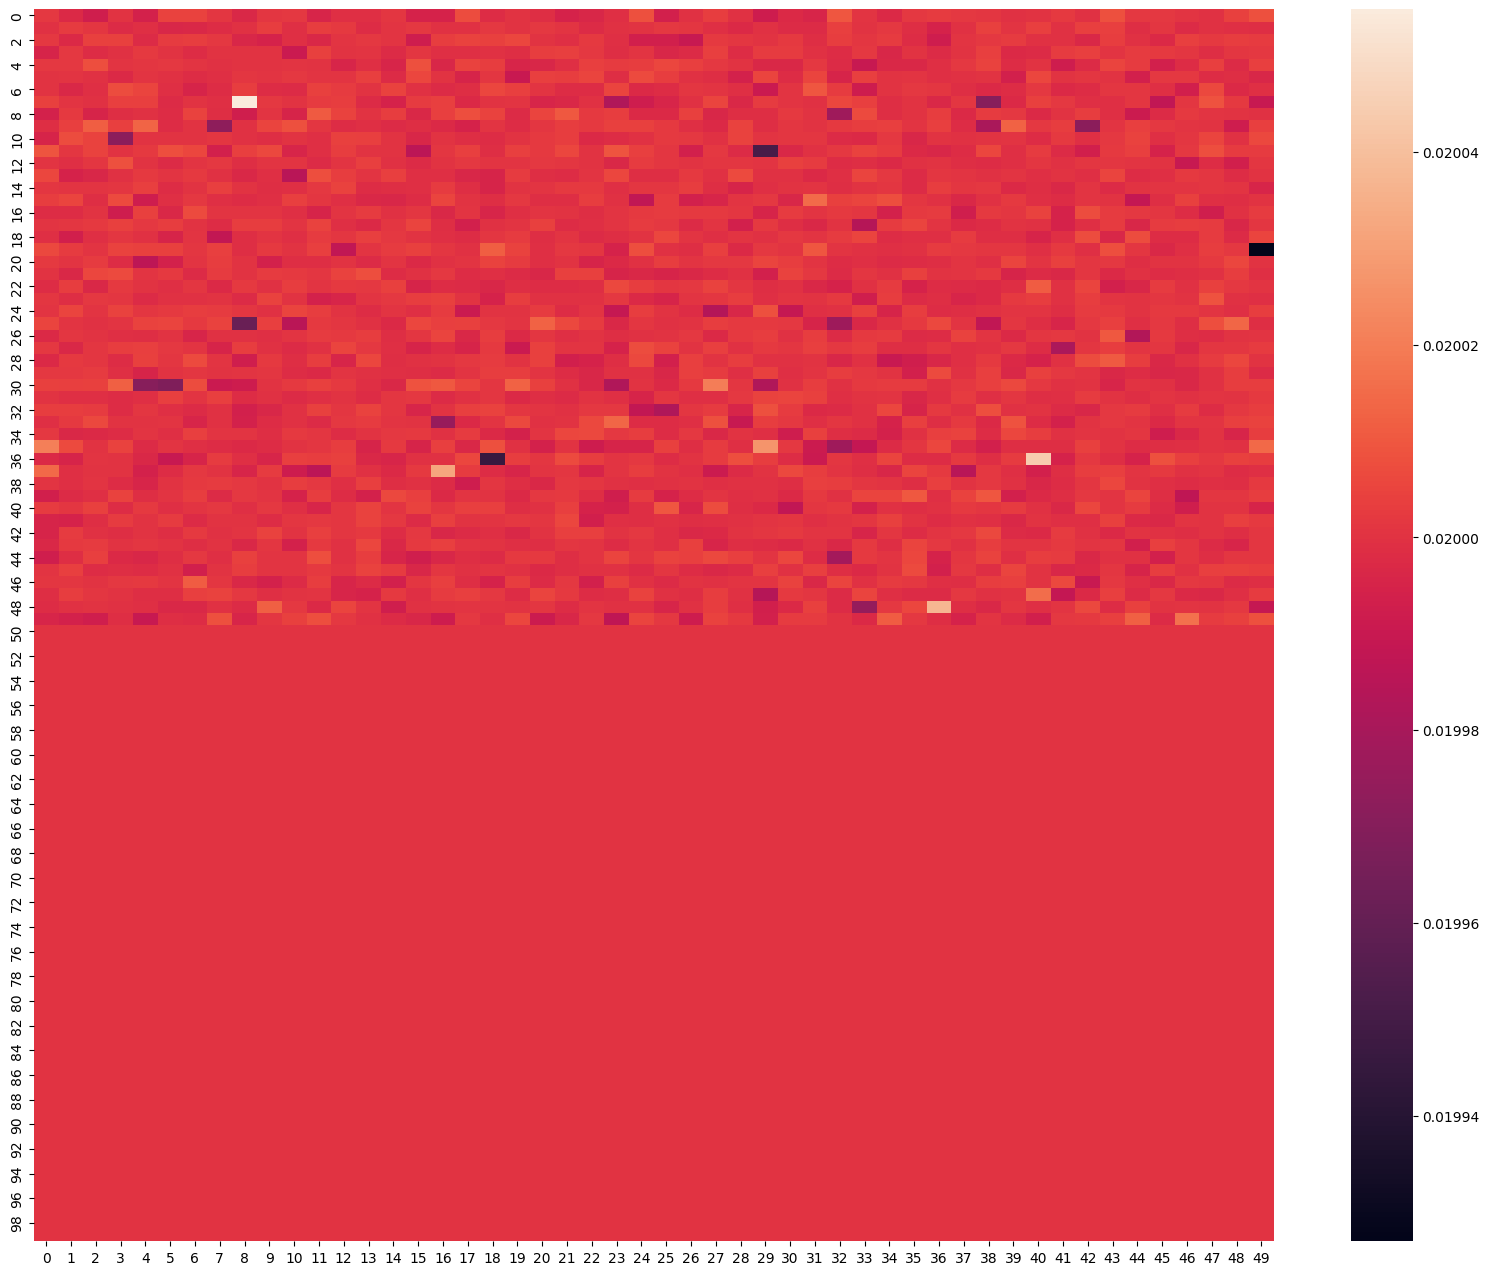

In [19]:
mydata = farm.view_policy().numpy()
plt.figure(figsize=(20, 16))  # Set the figure size
sns.heatmap(mydata[0])  # Create the heatmap
plt.show()  # Display the heatmap


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming mean_score_list is a list containing your data
mean_score_series = pd.Series(mean_score_list)

# Calculate the rolling average
rolling_mean = mean_score_series.rolling(window=10).mean()

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(mean_score_series, label='Original')
plt.plot(rolling_mean, 'r-', label='Rolling Average')
plt.title("episode # vs critic loss")
plt.legend(loc='upper left')
plt.show()


In [ ]:
plot_allele_frequencies_with_corrected_sorting(farm.initial_population,farm.marker_strength)

In [ ]:
plot_allele_frequencies_with_corrected_sorting(farm.current_population,farm.marker_strength)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

fig = plt.figure()
# Define the update function
def update(frame):
    plt.clf()  # clear current figure
    if frame == 0:
        data = farm.initial_population
    else:
        data = farm.current_population
    plot_allele_frequencies_with_corrected_sorting(data, farm.marker_strength)
    return plt.gca()
# Create the animation
ani = FuncAnimation(fig, update, frames=2, repeat=True)
# Save the animation
writer = PillowWriter(fps=1)  # set fps according to your needs
ani.save("animation.gif", writer=writer)


In [ ]:
plot_allele_frequencies_with_corrected_sorting(farm.initial_population,farm.marker_strength)
plot_allele_frequencies_with_corrected_sorting(farm.current_population,farm.marker_strength)

In [ ]:
#chromax select
#chromax cross
#repeat

In [ ]:
plot_allele_frequencies_with_corrected_sorting(farm.current_population, farm.marker_strength)

In [ ]:
farm.current_population[0][1:6]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Example function to update plot data (you'll replace this with your own logic)
def update_data(t):
    return np.sin(x + t)

# Create a figure and axis
fig, ax = plt.subplots()

# Initialize a line plot (you'll replace this with your own plot setup)
x = np.linspace(0, 2*np.pi, 200)
line, = ax.plot(x, np.sin(x))

# Animation update function (update your plot here in each cycle)
def update(frame):
    # Update the data (replace this with your plot update logic)
    y = update_data(frame)
    line.set_ydata(y)
    return line,

# Create animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 10, 0.1), blit=True)
ani.save('animation.gif', writer='imagemagick')
